In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Creating Adversarial examples for a classifier

# FGSM on pretrained VGG16



## Load model

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

model = VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

## Download some example real world images

In [ ]:
!wget https://upload.wikimedia.org/wikipedia/commons/b/b0/Elefant_%282%29.jpg -O elephant.jpg
!wget https://d-mf.ppstatic.pl/art/1q/n2/o1ovs2cgk80g440440go0/galeria01.1200.jpg -O car.jpg
!wget https://c.files.bbci.co.uk/12A9B/production/_111434467_gettyimages-1143489763.jpg -O cat.jpg
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/4/43/Cute_dog.jpg/1024px-Cute_dog.jpg -O dog.jpg

--2021-03-26 00:28:25--  https://upload.wikimedia.org/wikipedia/commons/b/b0/Elefant_%282%29.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4645394 (4.4M) [image/jpeg]
Saving to: ‘elephant.jpg’

elephant.jpg        100%[===================>]   4.43M  16.5MB/s    in 0.3s    

2021-03-26 00:28:25 (16.5 MB/s) - ‘elephant.jpg’ saved [4645394/4645394]

--2021-03-26 00:28:25--  https://d-mf.ppstatic.pl/art/1q/n2/o1ovs2cgk80g440440go0/galeria01.1200.jpg
Resolving d-mf.ppstatic.pl (d-mf.ppstatic.pl)... 195.8.99.3, 2a02:1320:ffff:0:195:8:99:3
Connecting to d-mf.ppstatic.pl (d-mf.ppstatic.pl)|195.8.99.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 141045 (138K) [image/jpeg]
Saving to: ‘car.jpg’

car.jpg             100%[===================>] 137.74K   284KB/s    in 0.5s    


## Utils

In [ ]:
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                                "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")

    # perform the inverse of the preprocessiing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
classes = []
for i in range(1000):
    tmp = np.zeros(shape=(1, 1000))
    tmp[0][i] = 1
    classes.append(decode_predictions(tmp, top=1)[0][0][1])

## Perform FGSM attack 

TARGETING CLASS mortar

car.jpg
Original pred: [(817, 'sports_car', 0.5), (751, 'racer', 0.31), (479, 'car_wheel', 0.04)]
Adversarial pred: [(35, 'mud_turtle', 0.2), (36, 'terrapin', 0.12), (915, 'yurt', 0.1)]


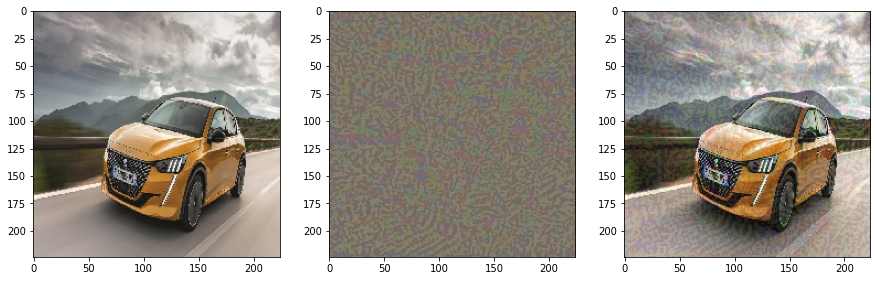




cat.jpg
Original pred: [(285, 'Egyptian_cat', 0.74), (281, 'tabby', 0.12), (282, 'tiger_cat', 0.11)]
Adversarial pred: [(588, 'hamper', 0.07), (748, 'purse', 0.06), (516, 'cradle', 0.02)]


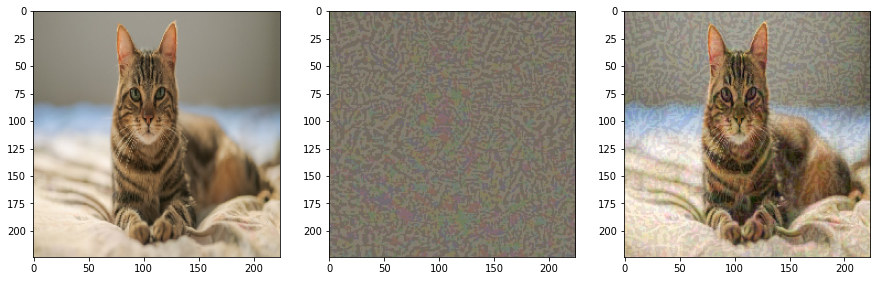




dog.jpg
Original pred: [(156, 'Blenheim_spaniel', 0.84), (218, 'Welsh_springer_spaniel', 0.14), (219, 'cocker_spaniel', 0.0)]
Adversarial pred: [(264, 'Cardigan', 0.17), (247, 'Saint_Bernard', 0.04), (180, 'American_Staffordshire_terrier', 0.03)]


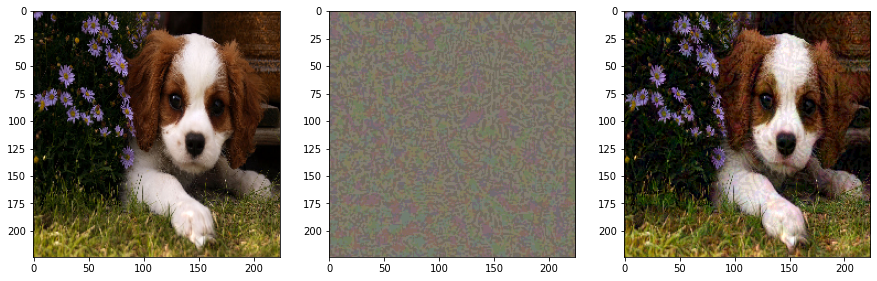




elephant.jpg
Original pred: [(386, 'African_elephant', 0.92), (101, 'tusker', 0.08), (385, 'Indian_elephant', 0.0)]
Adversarial pred: [(37, 'box_turtle', 0.08), (36, 'terrapin', 0.06), (35, 'mud_turtle', 0.05)]


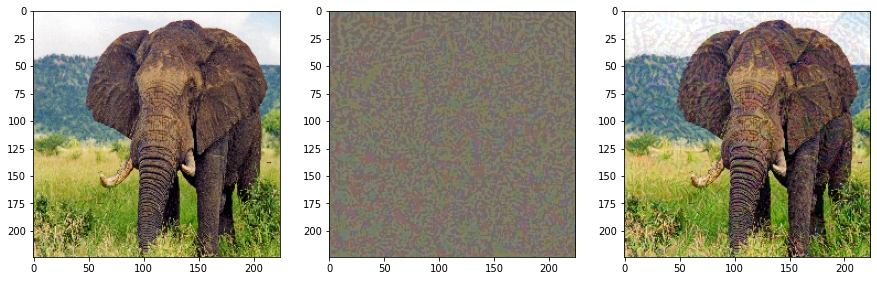

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from keras.losses import mean_absolute_error, mean_squared_error, SparseCategoricalCrossentropy

# Tried different losses, but SparseCategoricalCrossentropy seems to work the best (no surprise)
scce = SparseCategoricalCrossentropy()

def step(model, X, y):
    with tf.GradientTape() as tape:
        inp = tf.Variable(X, dtype=tf.float32)
        pred = model(inp)
        loss = scce([y] * len(pred) , pred)

    return tape.gradient(loss, inp)

top = 3
eps = 10 
target_class = 666

print(f"TARGETING CLASS {classes[target_class]}\n")

img_paths = ['car.jpg', 'cat.jpg', 'dog.jpg', 'elephant.jpg', ]
for img_path in img_paths:
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    print(img_path)

    # Normal img
    features = model.predict(x)
    ax[0].imshow(deprocess_img(x))
    class_numbers = features[0].argsort()[::-1][:top]
    dec_pred = decode_predictions(features, top=top)[0]

    print("Original pred:", [(class_num, name, round(score, 2)) for class_num, (_, name, score) in zip(class_numbers, dec_pred)])

    # Adv img

    # The essence of FGSM
    # #########################
    adv_part = eps * np.sign(step(model, x, target_class))
    x_adv = x - adv_part
    # #########################

    ax[1].imshow(deprocess_img(adv_part))

    features = model.predict(x_adv)
    ax[2].imshow(deprocess_img(x_adv))
    class_numbers = features[0].argsort()[::-1][:top]
    dec_pred = decode_predictions(features, top=top)[0]

    print("Adversarial pred:", [(class_num, name, round(score, 2)) for class_num, (_, name, score) in zip(class_numbers, dec_pred)])
    plt.show()
    print("\n\n")


Observations
- results seem to be totally messed up for adversarial images
- it's not easy to target a specific class
- tried different losses but, categorical crossentropy worked the best (probably because it was used during training the model)

# FGSM on MNIST

## Get dataset

In [ ]:
import keras 
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Reshape, Flatten, Dropout, LeakyReLU
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.utils import to_categorical
import numpy as np
from keras.datasets import mnist
import io
from keras.preprocessing.image import ImageDataGenerator

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape((60000, 28, 28, 1)) - 128.
x_test = x_test.reshape((10000, 28, 28, 1)) - 128.

img_shape = x_train.shape[1:]
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

## Define model

In [ ]:
model = Sequential([
    Conv2D(64, (3, 3), padding="same", activation="relu", input_shape=img_shape),
    # Conv2D(64, (3, 3), padding="same"),
    MaxPool2D(),
    Conv2D(128, (3, 3),activation="relu", padding="same"),
    # Conv2D(128, (3, 3), activation="relu", padding="same"),
    MaxPool2D(),
    Conv2D(256, (3, 3), activation="relu", padding="same"),
    # Conv2D(256, (3, 3), activation="relu", padding="same"),
    MaxPool2D(),
    Conv2D(512, (3, 3), activation="relu", padding="same"),
    MaxPool2D(),
    Flatten(),
    Dense(1024),
    Dropout(0.5),
    Dense(10, activation="softmax"),
])

model.compile(loss='categorical_crossentropy', 
            optimizer=Adam(learning_rate=1e-4),
            metrics=['categorical_accuracy'])

## Train it

In [ ]:
model.fit(x_train, y_train, 
          batch_size=128, 
          epochs=8, 
          validation_steps=16,
          validation_data=(x_test[:5000], y_test[:5000]), 
          validation_batch_size=128)

Epoch 1/8
469/469 [==============================] - 7s 13ms/step - loss: 1.4156 - categorical_accuracy: 0.7579 - val_loss: 0.1223 - val_categorical_accuracy: 0.9580
Epoch 2/8
469/469 [==============================] - 6s 13ms/step - loss: 0.0922 - categorical_accuracy: 0.9716 - val_loss: 0.0700 - val_categorical_accuracy: 0.9751
Epoch 3/8
469/469 [==============================] - 6s 13ms/step - loss: 0.0542 - categorical_accuracy: 0.9829 - val_loss: 0.0643 - val_categorical_accuracy: 0.9785
Epoch 4/8
469/469 [==============================] - 6s 13ms/step - loss: 0.0338 - categorical_accuracy: 0.9891 - val_loss: 0.0632 - val_categorical_accuracy: 0.9785
Epoch 5/8
469/469 [==============================] - 6s 13ms/step - loss: 0.0283 - categorical_accuracy: 0.9907 - val_loss: 0.0583 - val_categorical_accuracy: 0.9800
Epoch 6/8
469/469 [==============================] - 6s 13ms/step - loss: 0.0189 - categorical_accuracy: 0.9935 - val_loss: 0.0628 - val_categorical_accuracy: 0.9834
Epoc

## Good enough accuracy

In [ ]:
model.evaluate(x_test[5000:], y_test[5000:])

157/157 [==============================] - 0s 3ms/step - loss: 0.0177 - categorical_accuracy: 0.9942


[0.017736151814460754, 0.9941999912261963]

## Perform FGSM attack

TARGETING CLASS 0

7
Original pred: [(7, 1.0), (1, 0.0), (9, 0.0)]
Adversarial pred: [(7, 0.992), (8, 0.002), (1, 0.002)]


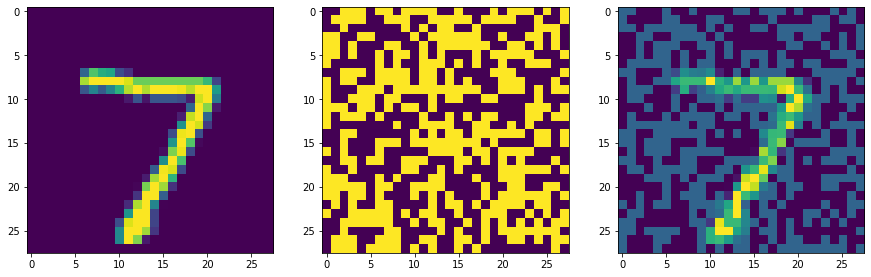




2
Original pred: [(2, 1.0), (7, 0.0), (1, 0.0)]
Adversarial pred: [(2, 0.941), (0, 0.039), (6, 0.02)]


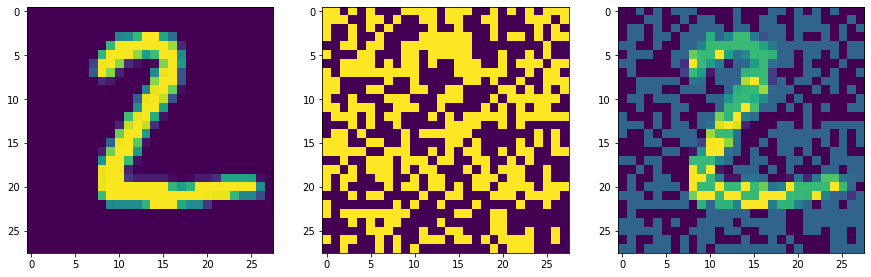




1
Original pred: [(1, 1.0), (7, 0.0), (4, 0.0)]
Adversarial pred: [(8, 0.874), (2, 0.09), (7, 0.023)]


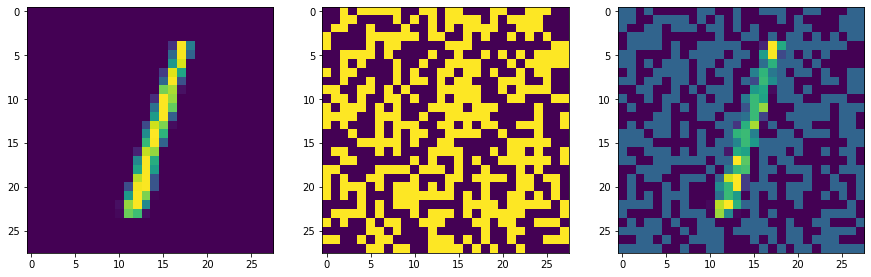




0
Original pred: [(0, 1.0), (6, 0.0), (7, 0.0)]
Adversarial pred: [(0, 1.0), (7, 0.0), (9, 0.0)]


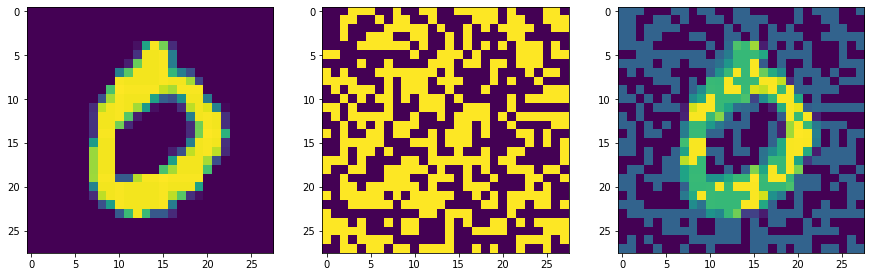

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from keras.losses import mean_absolute_error, mean_squared_error, SparseCategoricalCrossentropy

# Tried different losses, but SparseCategoricalCrossentropy seems to work the best (no surprise)
scce = SparseCategoricalCrossentropy()

def step(model, X, y):
    with tf.GradientTape() as tape:
        inp = tf.Variable(X, dtype=tf.float32)
        pred = model(inp)
        loss = scce([y] * len(pred) , pred)

    return tape.gradient(loss, inp)

top = 3
eps = 60
target_class = 0

print(f"TARGETING CLASS {0}\n")

num_adv = 4
for x, y in zip(x_test[:num_adv], y_test[:num_adv]):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    print(y.argmax())

    # Normal img
    features = model.predict(np.array([x]))
    ax[0].imshow(x[:, :, 0])
    class_numbers = features[0].argsort()[::-1][:top]
    print("Original pred:", [(c, round(features[0][c], 3)) for c in class_numbers])

    # Adv img
    adv_part = eps * np.sign(step(model, np.array([x]), target_class))
    x_adv = x - adv_part
    ax[1].imshow(adv_part[0, :, :, 0])

    features = model.predict(x_adv)
    ax[2].imshow(x_adv[0, :, :, 0])
    class_numbers = features[0].argsort()[::-1][:top]
    print("Adversarial pred:", [(c, round(features[0][c], 3)) for c in class_numbers])

    plt.show()
    print("\n\n")


Observations
- MNIST may be too easy task to perform adversarial attacks

# FGSM on CIFAR10



## Get dataset

In [ ]:
import keras 
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Reshape, Flatten, Dropout, LeakyReLU
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.utils import to_categorical
import numpy as np
from keras.datasets import cifar10
import io
from keras.preprocessing.image import ImageDataGenerator

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.reshape((50000, 32, 32, 3)) - 128.
x_test = x_test.reshape((10000, 32, 32, 3)) - 128.

img_shape = x_train.shape[1:]
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

## Define model

In [ ]:
model = Sequential([
    Conv2D(64, (3, 3), padding="same", activation="relu", input_shape=img_shape),
    Conv2D(64, (3, 3), padding="same"),
    MaxPool2D(),
    Conv2D(128, (3, 3),activation="relu", padding="same"),
    Conv2D(128, (3, 3), activation="relu", padding="same"),
    MaxPool2D(),
    Conv2D(256, (3, 3), activation="relu", padding="same"),
    Conv2D(256, (3, 3), activation="relu", padding="same"),
    MaxPool2D(),
    Conv2D(512, (3, 3), activation="relu", padding="same"),
    MaxPool2D(),
    Flatten(),
    Dense(1024),
    Dropout(0.5),
    Dense(10, activation="softmax"),
])

model.compile(loss='categorical_crossentropy', 
            optimizer=Adam(learning_rate=1e-4),
            metrics=['categorical_accuracy'])

## Train it

In [ ]:
model.fit(x_train, y_train, 
          batch_size=128, 
          epochs=16, 
          validation_steps=16,
          validation_data=(x_test[:5000], y_test[:5000]), 
          validation_batch_size=128)

Epoch 1/16
391/391 [==============================] - 11s 28ms/step - loss: 2.2506 - categorical_accuracy: 0.3037 - val_loss: 1.2572 - val_categorical_accuracy: 0.5596
Epoch 2/16
391/391 [==============================] - 11s 27ms/step - loss: 1.2344 - categorical_accuracy: 0.5589 - val_loss: 1.1001 - val_categorical_accuracy: 0.6177
Epoch 3/16
391/391 [==============================] - 11s 27ms/step - loss: 1.0026 - categorical_accuracy: 0.6493 - val_loss: 0.9446 - val_categorical_accuracy: 0.6626
Epoch 4/16
391/391 [==============================] - 11s 27ms/step - loss: 0.8302 - categorical_accuracy: 0.7094 - val_loss: 0.9051 - val_categorical_accuracy: 0.6851
Epoch 5/16
391/391 [==============================] - 11s 27ms/step - loss: 0.6541 - categorical_accuracy: 0.7723 - val_loss: 0.9000 - val_categorical_accuracy: 0.6968
Epoch 6/16
391/391 [==============================] - 11s 27ms/step - loss: 0.5291 - categorical_accuracy: 0.8168 - val_loss: 0.8371 - val_categorical_accuracy:

## Evaluate

In [ ]:
model.evaluate(x_test[5000:], y_test[5000:])

157/157 [==============================] - 1s 5ms/step - loss: 1.4070 - categorical_accuracy: 0.7246


[1.4070355892181396, 0.7246000170707703]

This model clearly overfits and accuracy on the test set is not impressive, however I think that in this case it is not that important

## FGSM attack

TARGETING CLASS 0

3
Original pred: [(3, 0.984), (5, 0.012), (8, 0.004)]
Adversarial pred: [(0, 1.0), (7, 0.0), (5, 0.0)]


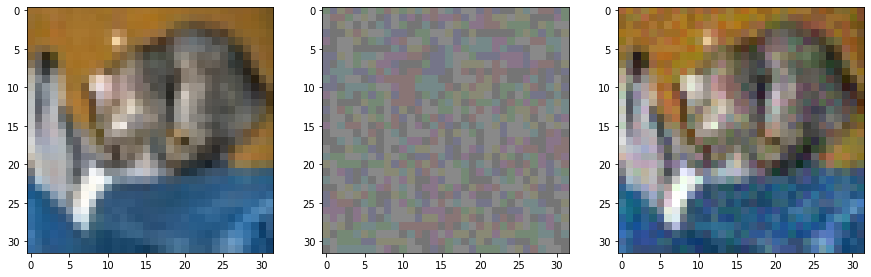




8
Original pred: [(8, 0.791), (1, 0.209), (0, 0.0)]
Adversarial pred: [(0, 0.999), (1, 0.001), (9, 0.0)]


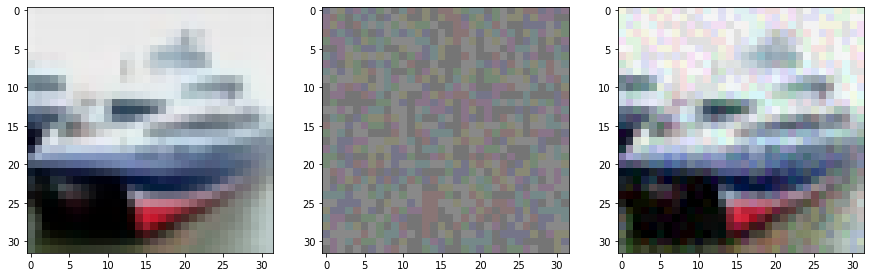




8
Original pred: [(8, 0.996), (1, 0.004), (0, 0.0)]
Adversarial pred: [(0, 0.992), (1, 0.008), (9, 0.0)]


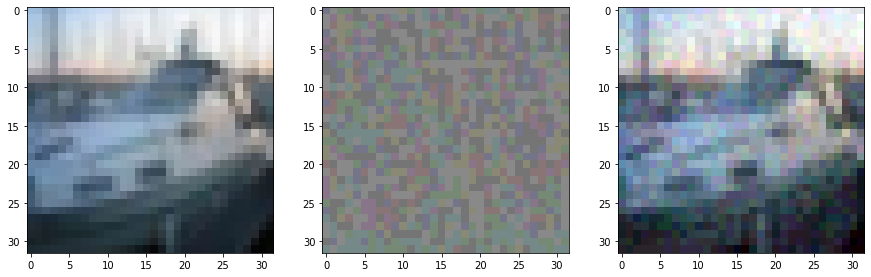




0
Original pred: [(0, 0.658), (1, 0.193), (8, 0.146)]
Adversarial pred: [(0, 1.0), (4, 0.0), (2, 0.0)]


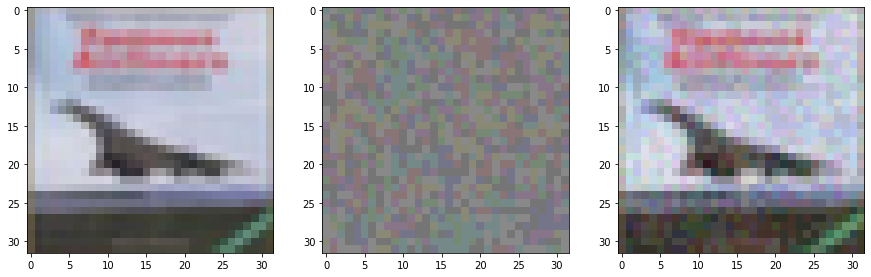




6
Original pred: [(6, 0.993), (4, 0.005), (2, 0.001)]
Adversarial pred: [(4, 0.995), (2, 0.005), (3, 0.0)]


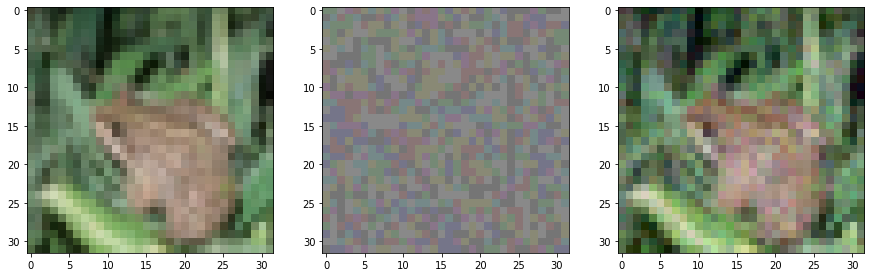




6
Original pred: [(6, 0.955), (4, 0.044), (5, 0.001)]
Adversarial pred: [(4, 0.997), (7, 0.002), (0, 0.001)]


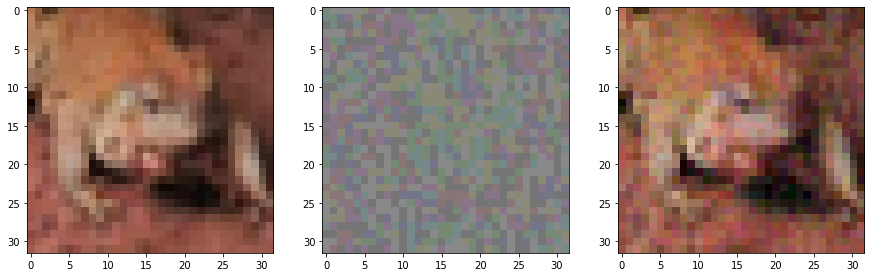

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from keras.losses import mean_absolute_error, mean_squared_error, SparseCategoricalCrossentropy

scce = SparseCategoricalCrossentropy()

def step(model, X, y):
    with tf.GradientTape() as tape:
        inp = tf.Variable(X, dtype=tf.float32)
        pred = model(inp)
        loss = scce([y] * len(pred) , pred)

    return tape.gradient(loss, inp)

top = 3
eps = 10
target_class = 0

print(f"TARGETING CLASS {0}\n")

num_adv = 6
for x, y in zip(x_test[:num_adv], y_test[:num_adv]):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    print(y.argmax())

    # Normal img
    features = model.predict(np.array([x]))
    ax[0].imshow(np.clip(x / 255. + 0.5, 0, 1))
    class_numbers = features[0].argsort()[::-1][:top]
    print("Original pred:", [(c, round(features[0][c], 3)) for c in class_numbers])

    # Adv img
    adv_part = eps * np.sign(step(model, np.array([x]), target_class))
    x_adv = np.clip(x - adv_part, -128, 128)
    ax[1].imshow(np.clip(adv_part[0] / 255. + 0.5, 0, 1))

    features = model.predict(x_adv)
    ax[2].imshow(np.clip(x_adv[0] / 255. + 0.5, 0, 1))
    class_numbers = features[0].argsort()[::-1][:top]
    print("Adversarial pred:", [(c, round(features[0][c], 3)) for c in class_numbers])

    plt.show()
    print("\n\n")


## Compare normal test set to adversarial test set

In [ ]:
# All labels to 0
x_adversarial_0 = []
for x in x_test[:1000]:
    adv_part = eps * np.sign(step(model, np.array([x]), 0))
    x_adv = np.clip(x - adv_part, -128, 127)
    x_adversarial_0.append(x_adv[0])

x_adversarial_0 = np.array(x_adversarial_0)

In [ ]:
# All labels to next % 10
x_adversarial_next = []
for x, y in zip(x_test[:1000], y_test[:1000]):
    adv_part = eps * np.sign(step(model, np.array([x]), (y.argmax() + 1) % 10))
    x_adv = np.clip(x - adv_part, -128, 127)
    x_adversarial_next.append(x_adv[0])

x_adversarial_next = np.array(x_adversarial_next)

In [ ]:
print("normal test set")
model.evaluate(x_test[:1000], y_test[:1000])
print("adversarial test set (all to 0)")
model.evaluate(x_adversarial_0, y_test[:1000])
print("adversarial test set (all to next % 10)")
model.evaluate(x_adversarial_next, y_test[:1000])

normal test set
32/32 [==============================] - 0s 6ms/step - loss: 1.2691 - categorical_accuracy: 0.7340
adversarial test set (all to 0)
32/32 [==============================] - 0s 5ms/step - loss: 9.2262 - categorical_accuracy: 0.1700
adversarial test set (all to next % 10)
32/32 [==============================] - 0s 5ms/step - loss: 12.6145 - categorical_accuracy: 0.0610


[12.614490509033203, 0.061000000685453415]

## Successful attack!

### Sanity check, that new dataset looks good 

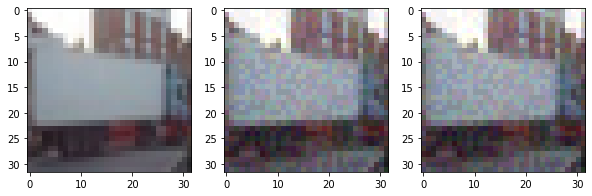

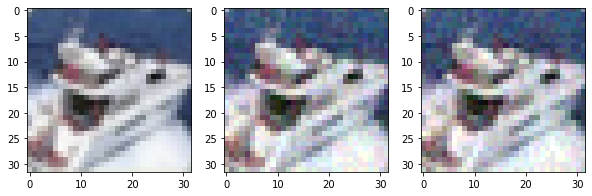

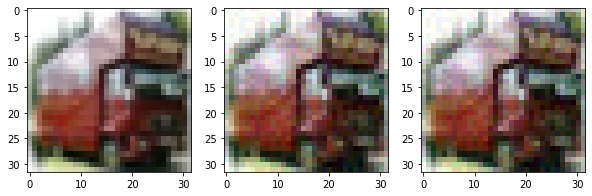

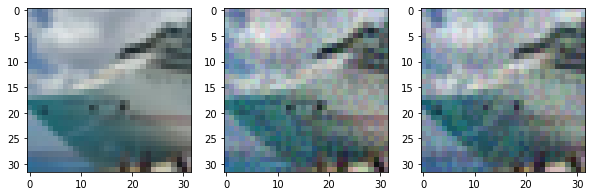

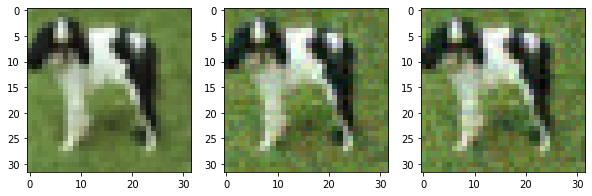

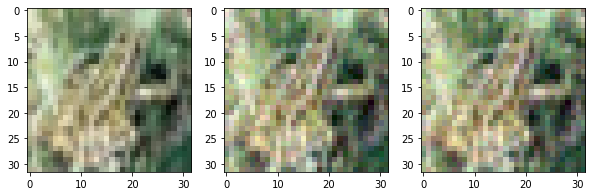

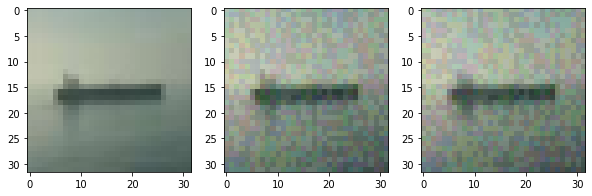

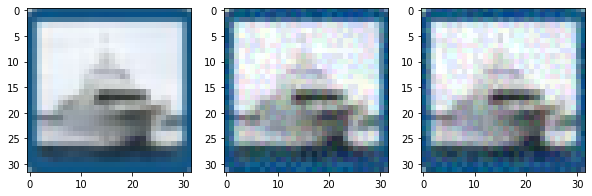

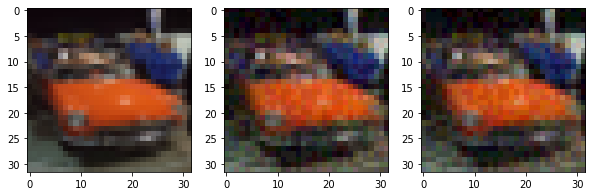

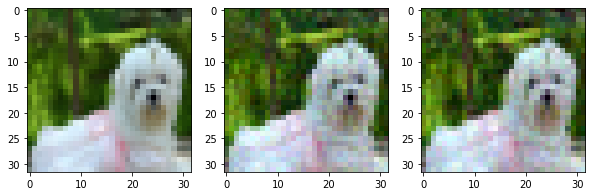

In [ ]:
num_samples = 10
for _ in range(num_samples):
    i = np.random.randint(0, 1000)
    _, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow((x_test[i] + 128 )/ 255. )
    ax[1].imshow((x_adversarial_0[i] + 128) / 255.)
    ax[2].imshow((x_adversarial_next[i] + 128) / 255.)
    plt.show()


# Adversarial CIFAR10 on DCGAN (finally)

## Load DCGAN trained on CIRAF10

In [ ]:
from keras.models import load_model

discriminator = load_model("/content/drive/MyDrive/ml/GAN/cifar10/train1/checkpoints/discriminator_last.h5")
generator = load_model("/content/drive/MyDrive/ml/GAN/cifar10/train1/checkpoints/generator_last.h5")

## Samples from generator

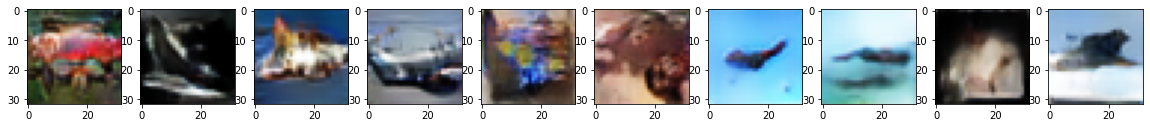

In [ ]:
x_random = tf.random.normal([10, 100]).numpy()
pred = generator.predict(x_random)
_, ax = plt.subplots(1, 10, figsize=(20, 4))
for i in range(10):
    ax[i].imshow((pred[i] + 1) / 2)

## Test DCGAN on test sets

(array([124.,   2.,   2.,   0.,   0.,   2.,   1.,   3.,   2., 864.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

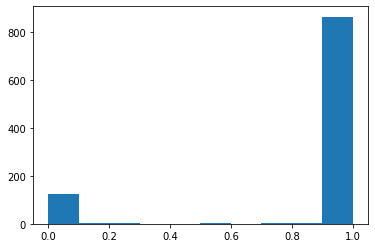

In [ ]:
pred_normal = discriminator.predict(x_test[:1000])
plt.hist(pred_normal)

(array([ 84.,   1.,   0.,   1.,   0.,   0.,   0.,   1.,   0., 913.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

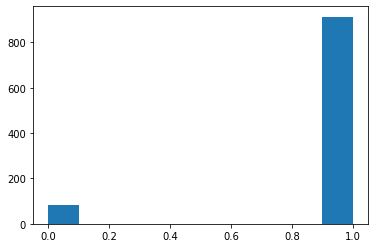

In [ ]:
pred_adv_0 = discriminator.predict(x_adversarial_0[:1000])
plt.hist(pred_adv_0)

(array([ 86.,   3.,   3.,   0.,   1.,   3.,   0.,   2.,   0., 902.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

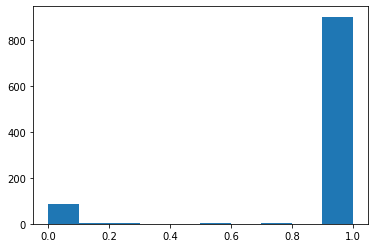

In [ ]:
pred_adv_next = discriminator.predict(x_adversarial_next[:1000])
plt.hist(pred_adv_next)

In [ ]:
print("normal", pred_normal.mean())
print("adv zero", pred_adv_0.mean())
print("adv next", pred_adv_next.mean())

normal 0.870506
adv zero 0.91406363
adv next 0.90678334


Observations
- discriminator does not see any difference between a normale and adversarial dataset
- maybe the dataset is to small and features learned by classifier are not easily transferable, thus adversarial attacks pointed at the classifier do not afect discriminator

# Conclusion
TLDR: No, discriminator cannot recognize adversarial images

## Future directions
- better training of classifier
- try other attacks
    - PGD
    - one pixel attacks
- test this on a larger dataset
    - I already have a DCGAN trained on CelebA
    - some other suggestions?
- try to use big pretrained GANs like StyleGan
    - https://www.justinpinkney.com/pretrained-stylegan/
- train discriminator on adv dataset